## MNIST

In this notebook we will be using MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

In [1]:
#import libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import warnings
warnings.filterwarnings("ignore")
import io

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]


In [3]:
try:
    from sklearn.datasets import fetch_openml
    MNIST  = fetch_openml('mnist_784', version=1, cache=True)
    MNIST.target = MNIST.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(MNIST) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    MNIST = fetch_mldata('MNIST original')
MNIST["data"], MNIST["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
MNIST.data.shape

(70000, 784)

In [5]:
X, y = MNIST['data'], MNIST['target']
print('X Shape:', X.shape, ', y Shape:', y.shape)

X Shape: (70000, 784) , y Shape: (70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset

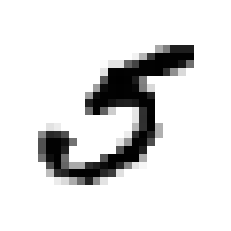

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
#looks like 9, y[67111] will confirm
y[36000]

5

MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last10,000 images). Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar.

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit — for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5.

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
y_train_5.sum()

5421

Next, we will pick a classifier and train it. Here, we'll start with Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class.

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5 ,cv = 3, scoring = 'accuracy')
#cross_val_score(sgd_clf, X_train, y_train_5 ,cv = 3, scoring = 'recall')
#cross_val_score(sgd_clf, X_train, y_train_5 ,cv = 3, scoring = 'precision')

array([0.96215, 0.96155, 0.95785])

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = 0):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype= bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring= 'accuracy')

array([0.90925, 0.90895, 0.91075])

It has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

### Confusion Matrix
The general idea is to count the number of times instances of class A are classified as class B. To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. 

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [17]:
y_train_pred.sum()

5998

In [18]:
y_train_5

array([False, False, False, ..., False, False, False])

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53106,  1473],
       [  896,  4525]], dtype=int64)

In [20]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### cross_val_predict vs cross_val_score:

Suppose there are 10 instances in the dataset and we use 2 folds of 5 instances each. Both cross_val_predict() and cross_val_score() will train two models, one on fold 1 and the other on fold 2. Both functions will use the model 1 to make predictions on fold 2, and model 2 to make predictions on fold 1. This gives two groups of predictions, P1 and P2, with 5 predictions each, for example:

P1=[9, 5, 4, 6, 2] and P2=[4, 5, 4, 3, 4].

Now suppose the labels are L=[9, 5, 4, 6, 2, 3, 6, 3, 2, 3].
You can see that the predictions P1 are perfect, while the predictions P2 are off by 1. Apparently, the first model was perfect, while the second was not.

Now cross_val_score() would compute the score independently for each group of predictions. Suppose we are using the MSE, this gives us: MSE(P1)=0 and MSE(P2)=(1^2+1^2+1^2+1^2)/4=1.
This is what cross_val_score() would report: [0, 1]. You can then compute the mean and get the final evaluation: 0.5.

Now let's look at cross_val_predict(). It would just return the concatenation of P1 and P2, losing the information about which prediction came from which model: [9, 5, 4, 6, 2, 4, 5, 4, 3, 4]. You can then compute the MSE, which is: (0^2+0^2+0^2+0^2+0^2+1^2+1^2+1^2+1^2+1^2)/10 = 0.5.
As you can see, you get the same final evaluation in this case. The benefit of cross_val_predict() is that you have access to the predictions, so you can plot them, analyze them, or use them to train blending models (see chapter 7). However, it hides the fact that some models were perfect while others were much worse.

If the metric is a simple mean over instance errors (e.g., mean squared error, or mean absolute error, or mean cross-entropy, etc.), then the final scores should always be the same. However, it's not always that simple. For example, consider the precision metric for a classification task (chapter 3). Suppose you are training a binary classifier, and the predictions are: P1=[1, 1, 1, 0, 1] and P2=[0, 0, 1, 1, 0].
Now suppose the labels are L=[1, 0, 1, 0, 1, 0, 1, 0, 1, 0]. The precision is the number of true positives divided by the number of positive predictions. So the precision over P1 is 3/4=75%, while the precision over P2 is 1/2=50%. So cross_val_score() will return [0.75, 0.5]. If you compute the mean, you get: 62.5%.
Now cross_val_predict() will just return the concatenated predictions P=[1, 1, 1, 0, 1, 0, 0, 1, 1, 0]. If you compute the precision, you get: 4/6=66.66%. That's a different result!

Should you trust cross_val_score() or cross_val_predict() then? Well, cross_val_score() is definitely preferable in this case, as it gives you more details about the variability of the metric depending on the trained model, while cross_val_predict() just fuses all the predictions from all folds, although they were made with different models.

### Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

print('Precision_score: ', round(precision_score(y_train_5, y_train_pred), 4),\
      '\nRecall_score:    ', round(recall_score(y_train_5, y_train_pred), 4), \
     '\nAccuracy_score:  ', round(accuracy_score(y_train_5, y_train_pred), 4), 
     '\nF1_score:        ', round(f1_score(y_train_5, y_train_pred), 4)) #f1 score, harmonic mean of precision and recall

Precision_score:  0.7544 
Recall_score:     0.8347 
Accuracy_score:   0.9605 
F1_score:         0.7925


**Recall = tp/(tp + fn)**: recall increases when the number of false negative decrease. 

**Precision = tp/(tp + fp)**: precision increases when the number of false positive decrease. 

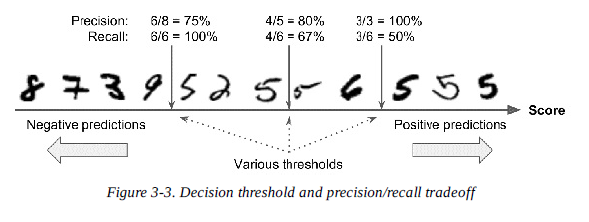



Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want:

In [22]:
y_score = sgd_clf.decision_function([some_digit])
y_score

array([2564.12968192])

In [23]:
thr = 0
y_some_digit_pred = (y_score > thr)
y_some_digit_pred

array([ True])

In [24]:
thr = 20000
y_some_digit_pred = (y_score > thr)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 20,000.

In order to decide which threshold to use, we will first need the score of all instances in the training set using the cross_val_predict() function again, but this time specifying that we want it to return decision scores instead of predictions:

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, 
                            cv = 3, method = 'decision_function') 

In [26]:
y_scores

array([-11229.51145449,  -5444.20250301, -18472.67420454, ...,
       -21129.68428914, -11049.91282387, -26849.68854101])

In [27]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)

In [28]:
precision_recall_curve(y_train_5, y_scores)

(array([0.09046157, 0.09044639, 0.0904479 , ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
        3.68935621e-04, 1.84467810e-04, 0.00000000e+00]),
 array([-77990.91233916, -77912.84959694, -77706.75291633, ...,
         30214.68273563,  33417.34893303,  34556.39290871]))

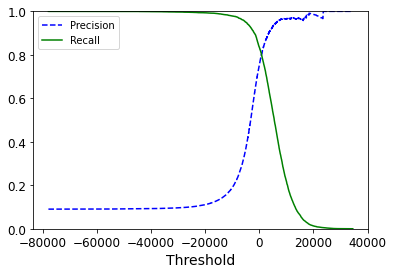

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precision, recall, threshold)
plt.show()

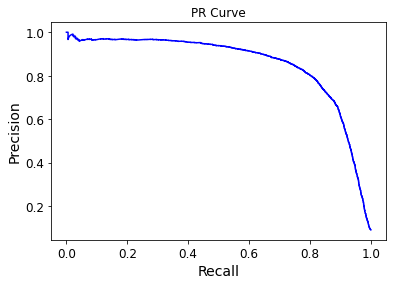

In [30]:
plt.plot(recall, precision, "b", label="Precision va recal")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')

plt.show()

So let’s suppose you decide to aim for 90% precision. You look up the first plot (zooming in a bit) and find that you need to use a threshold of about 1000. To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can just run this code:

In [31]:
y_train_pred_90 = (y_scores> 1000)
print('precision_score:', round(precision_score(y_train_5, y_train_pred_90), 3), \
      '\nrecall_score:', round(recall_score(y_train_5, y_train_pred_90), 3))

precision_score: 0.812 
recall_score: 0.792


### ROC Curve
The ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity. To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the roc_curve() function:


**Recall = TP / (TP + FN)**


**Specificity = TN /(TN + FP)**


Values|$$\mathbf{\hat{y} = 0}$$|$$\mathbf{\hat{y} = 1}$$|
:---:|:---:|:---:|
$$\mathbf{y = 0}$$|**TN**|**FP**|
$$\mathbf{y = 1}$$|**FN**|**TP**|

In [32]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

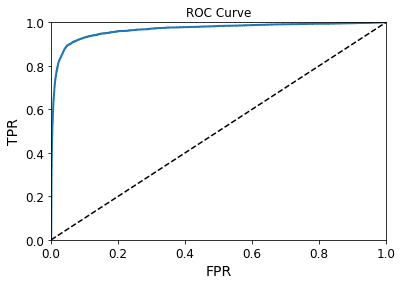

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    
plot_roc_curve(fpr, tpr)
plt.show()

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).
One way to compare classifiers is to measure the **Area Under the Curve (AUC)**. A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9670356269601691

Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC
AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be
closer to the top-right corner).

### RandomForestClassifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                 cv = 3, method= 'predict_proba')

In [36]:
#method=’predict_proba’, the columns correspond to the 
#classes in sorted order. for example if the output is [0.237, 0.762] means the probability
#that the output will be 0 is 0.237 and the probability of output being 1 is 0.762.
y_prob_forest

array([[0.91, 0.09],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [0.97, 0.03],
       [1.  , 0.  ]])

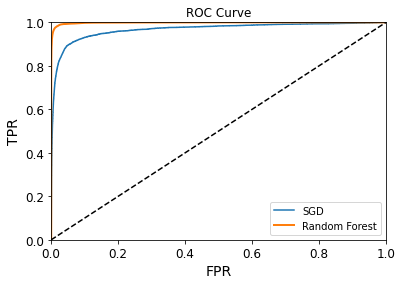

In [37]:
#But to plot a ROC curve, you need scores, not probabilities. 
#A simple solution is to use the positive
#class’s probability as the score:

y_scores_forest = y_prob_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, 
                                                      y_scores_forest)

plt.plot(fpr, tpr, label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, label = 'Random Forest')
plt.legend(loc = 'best')
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983782251477907

In [39]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)

In [40]:
print('Precision_score: ', round(precision_score(y_train_5, y_train_pred_forest), 4),\
      '\nRecall_score:    ', round(recall_score(y_train_5, y_train_pred_forest), 4), \
     '\nAccuracy_score:  ', round(accuracy_score(y_train_5, y_train_pred_forest), 4), 
     '\nF1_score:        ', round(f1_score(y_train_5, y_train_pred_forest), 4))

Precision_score:  0.9908 
Recall_score:     0.8716 
Accuracy_score:   0.9877 
F1_score:         0.9274


**Binary classifiers**: choose the appropriate metric for your task,
evaluate your classifiers using cross-validation, select the precision/recall tradeoff that fits your needs, and compare various models using ROC curves and ROC AUC scores. 

### Multiclass Classification

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). This is called the one-versus-all (OvA) strategy (also called one-versus-the-rest).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers!

The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.
Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.
Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO). Let’s try this with the SGDClassifier:

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [42]:
some_digit_score = sgd_clf.decision_function([some_digit])
some_digit_score

array([[ -6274.05439303, -19646.09450508, -15645.85970476,
         -4225.08282366, -15227.50749161,   2650.99905936,
        -31122.03367767, -21864.37618268, -11453.06640004,
        -15446.96331208]])

In [43]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the **OneVsOneClassifier** or **OneVsRestClassifier** classes. Simply create an instance and pass a binary classifier to its constructor.

In [44]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [45]:
some_digit_score = ovo_clf.decision_function([some_digit])
some_digit_score

array([[6.33333306, 2.66666706, 6.3333319 , 8.33333314, 2.66666705,
        9.33333318, 0.66666682, 4.66666784, 1.66666718, 1.6666672 ]])

In [46]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [47]:
forest_clf.predict_proba([some_digit])

array([[0.04, 0.  , 0.  , 0.05, 0.  , 0.91, 0.  , 0.  , 0.  , 0.  ]])

In [48]:
#Evaluation
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87875, 0.8759 , 0.87795])

In [49]:
#scaling the inputs
#increases accuracy above 90%
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.89855, 0.89805, 0.8967 ])

In [50]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5575,    0,   18,    5,    9,   32,   31,    7,  245,    1],
       [   0, 6421,   43,   16,    3,   42,    5,    7,  195,   10],
       [  25,   26, 5239,   87,   68,   20,   66,   40,  379,    8],
       [  26,   19,  116, 5223,    1,  180,   27,   38,  437,   64],
       [   9,   13,   41,    9, 5208,    8,   41,   18,  349,  146],
       [  25,   20,   26,  150,   49, 4397,   83,   16,  595,   60],
       [  29,   21,   44,    2,   39,   85, 5552,    5,  141,    0],
       [  19,   12,   49,   21,   47,   10,    5, 5712,  199,  191],
       [  15,   61,   38,   96,    3,  111,   32,    6, 5449,   40],
       [  21,   21,   30,   60,  127,   31,    1,  174,  394, 5090]],
      dtype=int64)

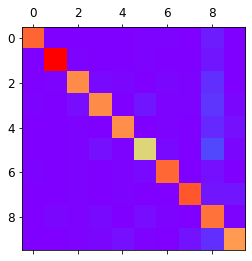

In [51]:
plt.matshow(conf_mx, cmap= plt.cm.rainbow)
plt.show()

In [52]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

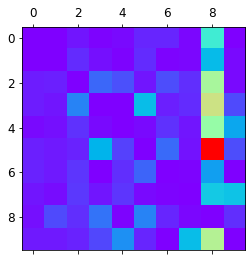

In [53]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap= plt.cm.rainbow)
plt.show()

In [54]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [55]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

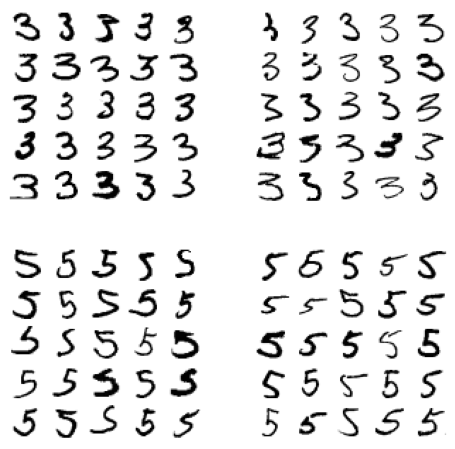

In [56]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred ==cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred ==cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred ==cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred ==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221) 
plot_digits(X_aa[:25], images_per_row=5)

plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)

plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)

plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
#save_fig("error_analysis_digits_plot")
plt.show()

### Multilabel Classification

Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”). Such a  classification system that outputs multiple binary labels is called a multilabel classification system.

In [57]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 != 0)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [58]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [59]:
#computing the average F1 score across all labels

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv = 3)
f1_score(y_train, y_train_knn_pred, average = 'macro') # average'macro':Calculate metrics for each label, and find their unweighted mean. 

0.9676665588950467

This assumes that all labels are equally important, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" in the preceding code.

### Multioutput Classification

It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values). To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system. 
Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities using NumPy’s randint() function. The target images will be the original images:

In [60]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

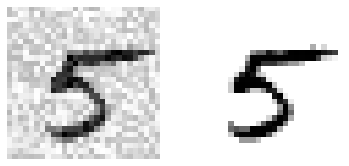

In [61]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

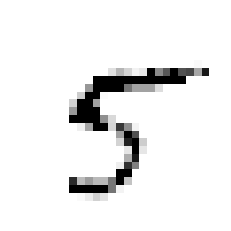

In [62]:
#Now let’s train the classifier and make it clean this image:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [63]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv = 3, 
                                method = 'predict_proba')

y_scores_dmy = y_probas_dmy[:, 1]

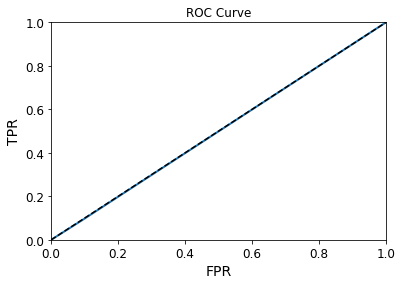

In [64]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr) 

### KNN classifier

In [65]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 
               'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf, param_grid, cv = 5, verbose = 3, 
                          n_jobs = -1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed: 153.1min remaining: 23.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 154.4min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [66]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [67]:
grid_search.best_score_

0.9735999999999999

In [68]:
y_pred = grid_search.predict(X_test)

In [69]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9714

We achieved accuracy over 97% on the test set, by tuning hyperparameters in KNN classifier.